# Missing link prediction - Kaggle competition

### Libraries

In [583]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import csv


In [30]:
import igraph
import networkx as nx

In [32]:
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [66]:
import gensim
from gensim.models import Doc2Vec
from textblob import TextBlob

### Read data

In [16]:
with open("training_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

with open("testing_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

In [17]:
n_info = pd.read_csv('node_information.csv',header=None)
colnames = ['id','year','title','author','journal','abstract']
n_info.columns = colnames

In [324]:
n_info.shape

NameError: name 'n_info' is not defined

In [25]:
# Visualize graph data

print('_____________________________')
print('training sample:')
print(training_set[:1])
print('_____________________________')
print('testing sample:')
print(testing_set[:1])
print('_____________________________')

_____________________________
training sample:
[['9510123', '9502114', '1']]
_____________________________
testing sample:
[['9807076', '9807139']]
_____________________________


# Cleaning and processing

### Cleaning of Author names to remove duplicates 

In [134]:
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [5]:
net = pd.read_csv('checkpoint1.csv')

In [394]:
net

,Unnamed: 0,id,year,title,author,journal,abstract,abstract_reduced,title_reduced,abstit_reduced
0,0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...,tasi99 geometry moduli space n point view comp...,compactification geometry duality,tasi99 geometry moduli space n point view comp...
1,1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,massive supergravity example due massive breat...,domain massive supergravity,massive supergravity example due massive breat...
2,2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...,ivanov volovich hep-th perturbation h mu nu no...,comment metric brane,ivanov volovich hep-th perturbation h mu nu no...
3,3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...,quantum rise assumption such work mirror exter...,thermodynamic,quantum rise assumption such work mirror exter...
4,4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...,lie iii clausthal july various chiral particul...,chiral boundary cft,lie iii clausthal july various chiral particul...
...,...,...,...,...,...,...,...,...,...,...
27765,27765,9912289,2002,gauge fixing in the chain by chain method,"A Shirzad, F Loran",NaN,in a recent work we showed that for a hamilton...,recent work hamiltonian system set first secon...,gauge fixing chain chain method,recent work hamiltonian system set first secon...
27766,27766,9912290,2000,shuffling quantum field theory,Dirk Kreimer,Lett.Math.Phys.,we discuss shuffle identities between feynman ...,shuffle feynman graphs hopf algebra structure ...,quantum field theory,shuffle feynman graphs hopf algebra structure ...
27767,27767,9912291,1999,small object limit of casimir effect and the s...,"O. Kenneth, S. Nussinov",Phys.Rev.,we show a simple way of deriving the casimir p...,simple way casimir polder interaction general ...,small object limit casimir effect sign casimir...,simple way casimir polder interaction general ...
27768,27768,9912292,1999,1 4 pbgs and superparticle actions,"F.Delduc, E. Ivanov, S. Krivonos",NaN,karpacz poland september 21-25 1999 we constru...,karpacz poland 21-25 worldline massive superpa...,pbgs superparticle,karpacz poland 21-25 worldline massive superpa...


In [148]:
# Remove universities in parenthesis

auth_no_uni = net.author.apply(lambda x: re.sub(r'\([^)]*\)', '', str(x)))

In [358]:
# Separate authors in different columns

auth_col_split = auth_no_uni.str.split(", ",expand=True,)

# Merge all authors in one column

sing_auth_list = pd.DataFrame(auth_col_split.stack().tolist()).drop_duplicates().dropna()

In [275]:
# Helper function to get only first and last names without middle names

def getFirstAndLastWords(author):
    if author != '':
        i = author.split()
        res = i[0] ,i[-1]
        res = ' '.join(res)
    if author == '':
        res = ''
    if author == None:
        res = ''
    return res

In [276]:
# Helper function to get only initial of the first name 

def getFirstNameInitial(author):
    if author != '':
        i = author.split()
        res = i[0][0], i[1]
        res = ' '.join(res)
    if author == '':
        res = ''
    if author == None:
        res = ''
    return res

In [314]:
# Cleaning pipeline 

def pipeAuthClean0(c):
    
    #for col in range(len(c.columns)):
    c = c[0].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [315]:
# Cleaning pipeline 

def pipeAuthClean1(c):
    
    #for col in range(len(c.columns)):
    c = c[1].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [316]:
# Cleaning pipeline 

def pipeAuthClean2(c):
    
    #for col in range(len(c.columns)):
    c = c[2].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [317]:
# Cleaning pipeline 

def pipeAuthClean3(c):
    
    #for col in range(len(c.columns)):
    c = c[3].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [318]:
# Cleaning pipeline 

def pipeAuthClean4(c):
    
    #for col in range(len(c.columns)):
    c = c[4].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [319]:
# Cleaning pipeline 

def pipeAuthClean5(c):
    
    #for col in range(len(c.columns)):
    c = c[5].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [320]:
# Cleaning pipeline 

def pipeAuthClean6(c):
    
    #for col in range(len(c.columns)):
    c = c[6].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [321]:
# Cleaning pipeline 

def pipeAuthClean7(c):
    
    #for col in range(len(c.columns)):
    c = c[7].str.strip()
    c = c.apply(lambda x: str(x).replace('.', '. '))    # Put space after each dot
    c = c.apply(lambda x: re.sub(' +', ' ', str(x)))    # Normalize all spaces down to one space
    c = c.apply(lambda x: x.split('(', 1)[0])           # Remove all characters after a parenthesis
    c = c.apply(lambda x: getFirstAndLastWords(str(x)))
    c = c.apply(lambda x: getFirstNameInitial(str(x)))
    c = c.apply(lambda x: str(x).replace('N None', ''))
    c = pd.DataFrame(c)
    #res = res.assign(i = c)
    #c = c.drop_duplicates()
    
    return c

In [322]:
c0 = pipeAuthClean0(auth_col_split)
c1 = pipeAuthClean1(auth_col_split)
c2 = pipeAuthClean2(auth_col_split)
c3 = pipeAuthClean3(auth_col_split)
c4 = pipeAuthClean4(auth_col_split)
c5 = pipeAuthClean5(auth_col_split)
c6 = pipeAuthClean6(auth_col_split)
c7 = pipeAuthClean7(auth_col_split)

In [344]:
clean_auth = pd.concat([c0,c1, c2, c3, c4, c5, c6 ,c7],axis=1)
colnames = ['Author 1', 'Author 2','Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7', 'Author 8']
clean_auth.columns = colnames

In [352]:
clean_auth['combined'] = clean_auth[colnames].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
clean_auth['combined'] = clean_auth['combined'].apply(lambda x: x.split(', ,', 1)[0]) 
end = clean_auth['combined']

In [353]:
end

0                           P Aspinwall
1                M Cvetic, H Lu, C Pope
2                       Y Myung, G Kang
3                              A Helfer
4                 J Fuchs, C Schweigert
                      ...              
27765                A Shirzad, F Loran
27766                         D Kreimer
27767             O Kenneth, S Nussinov
27768    F Delduc, E Ivanov, S Krivonos
27769                        L Cornalba
Name: combined, Length: 27770, dtype: object

In [373]:
# Separate authors in different columns

split_auth = end.str.split(", ",expand=True,)

# Merge all authors in one column

auth_list = pd.DataFrame(split_auth.stack().tolist()).drop_duplicates().dropna()[0].tolist()

In [381]:
# Test: print all rows containing substring 'sub'

sub= 'Johnson'
print("\n".join(s for s in auth_list if sub in s))

C Johnson
P Johnson
S Johnson
K Johnson
M Johnson


In [380]:
process.extract("Johnson", auth_list, limit=5)

[('C Johnson', 95),
 ('P Johnson', 95),
 ('S Johnson', 95),
 ('K Johnson', 95),
 ('M Johnson', 95)]

In [382]:
end

0                           P Aspinwall
1                M Cvetic, H Lu, C Pope
2                       Y Myung, G Kang
3                              A Helfer
4                 J Fuchs, C Schweigert
                      ...              
27765                A Shirzad, F Loran
27766                         D Kreimer
27767             O Kenneth, S Nussinov
27768    F Delduc, E Ivanov, S Krivonos
27769                        L Cornalba
Name: combined, Length: 27770, dtype: object

In [424]:
checkpoint2 = pd.concat([net, end], axis=1)
checkpoint2 = checkpoint2.drop(['author'], axis=1)
checkpoint2 = checkpoint2.rename(columns = {'combined':'author'})
checkpoint2 = checkpoint2.reset_index()

In [426]:
checkpoint2.to_csv('checkpoint2.csv')

In [425]:
checkpoint2

,id,index,Unnamed: 0,year,title,journal,abstract,abstract_reduced,title_reduced,abstit_reduced,author
0,1001,0,0,2000,compactification geometry and duality,NaN,these are notes based on lectures given at tas...,tasi99 geometry moduli space n point view comp...,compactification geometry duality,tasi99 geometry moduli space n point view comp...,P Aspinwall
1,1002,1,1,2000,domain walls and massive gauged supergravity p...,Class.Quant.Grav.,we point out that massive gauged supergravity ...,massive supergravity example due massive breat...,domain massive supergravity,massive supergravity example due massive breat...,"M Cvetic, H Lu, C Pope"
2,1003,2,2,2000,comment on metric fluctuations in brane worlds,NaN,recently ivanov and volovich hep-th 9912242 cl...,ivanov volovich hep-th perturbation h mu nu no...,comment metric brane,ivanov volovich hep-th perturbation h mu nu no...,"Y Myung, G Kang"
3,1004,3,3,2000,moving mirrors and thermodynamic paradoxes,Phys.Rev.,quantum fields responding to moving mirrors ha...,quantum rise assumption such work mirror exter...,thermodynamic,quantum rise assumption such work mirror exter...,A Helfer
4,1005,4,4,2000,bundles of chiral blocks and boundary conditio...,NaN,proceedings of lie iii clausthal july 1999 var...,lie iii clausthal july various chiral particul...,chiral boundary cft,lie iii clausthal july various chiral particul...,"J Fuchs, C Schweigert"
...,...,...,...,...,...,...,...,...,...,...,...
27765,9912289,27765,27765,2002,gauge fixing in the chain by chain method,NaN,in a recent work we showed that for a hamilton...,recent work hamiltonian system set first secon...,gauge fixing chain chain method,recent work hamiltonian system set first secon...,"A Shirzad, F Loran"
27766,9912290,27766,27766,2000,shuffling quantum field theory,Lett.Math.Phys.,we discuss shuffle identities between feynman ...,shuffle feynman graphs hopf algebra structure ...,quantum field theory,shuffle feynman graphs hopf algebra structure ...,D Kreimer
27767,9912291,27767,27767,1999,small object limit of casimir effect and the s...,Phys.Rev.,we show a simple way of deriving the casimir p...,simple way casimir polder interaction general ...,small object limit casimir effect sign casimir...,simple way casimir polder interaction general ...,"O Kenneth, S Nussinov"
27768,9912292,27768,27768,1999,1 4 pbgs and superparticle actions,NaN,karpacz poland september 21-25 1999 we constru...,karpacz poland 21-25 worldline massive superpa...,pbgs superparticle,karpacz poland 21-25 worldline massive superpa...,"F Delduc, E Ivanov, S Krivonos"


### Cleaning of abstracts prior to doc2vec

# Feature Engineering

## Doc2vec

Embedding on title or abstract or both

In [54]:
# Print sample title

sample = 8
n_info['title'][sample]

'gluon pair production from space-time dependent chromofield'

In [81]:
# Print sample title

sample = 0
n_info['abstract'][sample]

'these are notes based on lectures given at tasi99 we review the geometry of the moduli space of n 2 theories in four dimensions from the point of view of superstring compactification the cases of a type iia or type iib string compactified on a calabi-yau threefold and the heterotic string compactified on k3xt2 are each considered in detail we pay specific attention to the differences between n 2 theories and n 2 theories the moduli spaces of vector multiplets and the moduli spaces of hypermultiplets are reviewed in the case of hypermultiplets this review is limited by the poor state of our current understanding some peculiarities such as mixed instantons and the non-existence of a universal hypermultiplet are discussed'

- Observation: 

Even after basic text cleaning (stopwords, lemmas), it seems that co-occuring verbs (ex: compute) and adjectives (ex: different, important) will biase the embedding. However, some adjectives are informative (ex: non-abelian).

### Extracting nouns and adjectives from each abstract

In [83]:
# Extract word if noun or proper noun or adjective

def get_adjnoun(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if (tag == "JJ" or tag=="NN" or tag=="NNP")]

In [93]:
n_info['abstract_reduced'] = n_info['abstract'].apply(get_adjnoun)

In [99]:
n_info['title_reduced'] = n_info['title'].apply(get_adjnoun)

In [102]:
# To string

n_info['abstract_reduced']= n_info['abstract_reduced'].apply(lambda x: ' '.join(x))
n_info['title_reduced'] = n_info['title_reduced'].apply(lambda x: ' '.join(x))

In [103]:
# Join title and abstract

n_info['abstit_reduced'] = n_info[['abstract_reduced', 'title_reduced']].apply(lambda x: ''.join(x), axis=1)

Checkpoint

In [105]:
n_info.to_csv('checkpoint1.csv')

In [106]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in n_info['abstit_reduced'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print("Number of texts processed: ", j)

Number of texts processed:  27770


In [107]:
d2v_model = Doc2Vec(all_content_train, size = 100, window = 1, min_count = 2, workers=-1) #, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=20) #,start_alpha=0.002, #end_alpha=-0.016)

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


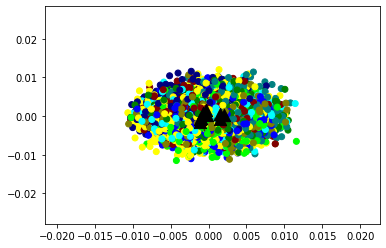

In [108]:
kmeans_model = KMeans(n_clusters=10, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ['#FFFF00', '#800000', '#FFFF00', '#808000','#00FF00','#008000','#00FFFF','#008080','#0000FF','#000080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [399]:
n = pd.read_csv('node_information.csv')

In [400]:
n.head()

,1001,2000,compactification geometry and duality,Paul S. Aspinwall,Unnamed: 4,these are notes based on lectures given at tasi99 we review the geometry of the moduli space of n 2 theories in four dimensions from the point of view of superstring compactification the cases of a type iia or type iib string compactified on a calabi-yau threefold and the heterotic string compactified on k3xt2 are each considered in detail we pay specific attention to the differences between n 2 theories and n 2 theories the moduli spaces of vector multiplets and the moduli spaces of hypermultiplets are reviewed in the case of hypermultiplets this review is limited by the poor state of our current understanding some peculiarities such as mixed instantons and the non-existence of a universal hypermultiplet are discussed
0,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
1,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
2,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
3,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...
4,1006,2000,questions in quantum physics,Rudolf Haag,NaN,an assessment of the present status of the the...


In [398]:
net

,Unnamed: 0,id,year,title,author,journal,abstract,abstract_reduced,title_reduced,abstit_reduced
0,0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...,tasi99 geometry moduli space n point view comp...,compactification geometry duality,tasi99 geometry moduli space n point view comp...
1,1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...,massive supergravity example due massive breat...,domain massive supergravity,massive supergravity example due massive breat...
2,2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...,ivanov volovich hep-th perturbation h mu nu no...,comment metric brane,ivanov volovich hep-th perturbation h mu nu no...
3,3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...,quantum rise assumption such work mirror exter...,thermodynamic,quantum rise assumption such work mirror exter...
4,4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...,lie iii clausthal july various chiral particul...,chiral boundary cft,lie iii clausthal july various chiral particul...
...,...,...,...,...,...,...,...,...,...,...
27765,27765,9912289,2002,gauge fixing in the chain by chain method,"A Shirzad, F Loran",NaN,in a recent work we showed that for a hamilton...,recent work hamiltonian system set first secon...,gauge fixing chain chain method,recent work hamiltonian system set first secon...
27766,27766,9912290,2000,shuffling quantum field theory,Dirk Kreimer,Lett.Math.Phys.,we discuss shuffle identities between feynman ...,shuffle feynman graphs hopf algebra structure ...,quantum field theory,shuffle feynman graphs hopf algebra structure ...
27767,27767,9912291,1999,small object limit of casimir effect and the s...,"O. Kenneth, S. Nussinov",Phys.Rev.,we show a simple way of deriving the casimir p...,simple way casimir polder interaction general ...,small object limit casimir effect sign casimir...,simple way casimir polder interaction general ...
27768,27768,9912292,1999,1 4 pbgs and superparticle actions,"F.Delduc, E. Ivanov, S. Krivonos",NaN,karpacz poland september 21-25 1999 we constru...,karpacz poland 21-25 worldline massive superpa...,pbgs superparticle,karpacz poland 21-25 worldline massive superpa...


## Pairwise cosine similarity between source and target

In [455]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [501]:
df_cos = node_info[['id','abstit_reduced']]

In [507]:
df_cos[df_cos['id']==1005].index

Int64Index([4], dtype='int64')

In [466]:
text = df_cos.abstit_reduced.tolist()

In [677]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def getCosineSim(t,vectors): 
    return cosine_similarity(vectors)
    
def getCountVectors(t):
    vectorizer = CountVectorizer(t)
    vectorizer.fit(t)
    return vectorizer.transform(t).toarray()

def getTFIDFVectors(t):
    vectorizer = TfidfVectorizer(t)
    return vectorizer.fit_transform(t)

In [678]:
vectors = getTFIDFVectors(text)

In [473]:
ivectors = getVectors(text)


In [679]:
def pairwiseCosineSim(vec1, vec2):
    vec1 = df_cos[df_cos['id']==vec1].index
    vec2 = df_cos[df_cos['id']==vec2].index
    vec1 = vectors[vec1]
    vec2 = vectors[vec2]
    vec1 = vec1.reshape(1,-1)
    vec2 = vec2.reshape(1,-1)
    return cosine_similarity(vec1, vec2)[0][0]

In [680]:
pairwiseCosineSim(9901042, 9510135)

0.11735971067247217

In [681]:
def getCosineSimFromSet(s):
    similarities = []
    for i in range(len(s)):
        res = pairwiseCosineSim(int(s[i][0]),int(s[i][1]))
        similarities.append(res)
    
    return similarities

In [682]:
red = training_set[:10]
red

[['9510123', '9502114', '1'],
 ['9707075', '9604178', '1'],
 ['9312155', '9506142', '0'],
 ['9911255', '302165', '0'],
 ['9701033', '209076', '0'],
 ['9710020', '9709228', '1'],
 ['9901042', '9510135', '1'],
 ['209146', '9502077', '0'],
 ['9705079', '9702201', '1'],
 ['3016', '9207067', '0']]

In [683]:
pairwiseCosineSim(int(red[2][0]),int(red[2][1]))

0.018897485774438928

In [684]:
len(training_set)

615512

In [699]:
pl.to_csv('cosine_train.csv')

In [695]:
cos_sim_training = getCosineSimFromSet(training_set)

In [697]:
cs = pd.DataFrame(cos_sim_training)
ts = pd.DataFrame(training_set)
pl = pd.concat([ts,cs], axis=1)

In [698]:
pl

,0,1,2,0
0,9510123,9502114,1,0.253769
1,9707075,9604178,1,0.040928
2,9312155,9506142,0,0.018897
3,9911255,302165,0,0.011424
4,9701033,209076,0,0.063212
...,...,...,...,...
615507,9704211,9311015,1,0.103565
615508,9709133,9202062,0,0.000000
615509,7141,9610152,0,0.008035
615510,207232,111196,1,0.000000


In [687]:
cols = ['node1','node2','is_link','cos_sim']
pl.columns = cols

In [688]:
pl

,node1,node2,is_link,cos_sim
0,9510123,9502114,1,0.253769
1,9707075,9604178,1,0.040928
2,9312155,9506142,0,0.018897
3,9911255,302165,0,0.011424
4,9701033,209076,0,0.063212
...,...,...,...,...
610,9811176,5093,0,0.013803
611,204195,9807026,0,0.020652
612,105279,302011,0,0.144541
613,303150,110244,1,0.200385


In [689]:
pl = pl.sort_values(by='cos_sim',ascending=False)

In [690]:
pl[pl['is_link']=='1']

,node1,node2,is_link,cos_sim
355,9406071,9307195,1,0.756379
376,101101,6180,1,0.722712
219,6221,6220,1,0.645672
72,9502159,9408096,1,0.515227
407,304233,103094,1,0.514071
...,...,...,...,...
90,9902022,9806095,1,0.000000
131,301140,207130,1,0.000000
451,6191,3236,1,0.000000
264,9805148,9801029,1,0.000000


In [691]:
mask1 = pl[pl['is_link']=='0']
mask2 = pl[pl['is_link']=='1']

#plt.bar(x[mask1], y[mask1], color = 'red')
#plt.bar(x[mask2], y[mask2], color = 'blue')
#plt.show()

In [692]:
mask1 = mask1.sort_values(by = 'cos_sim', ascending=False)
mask2 = mask2.sort_values(by = 'cos_sim', ascending=False)

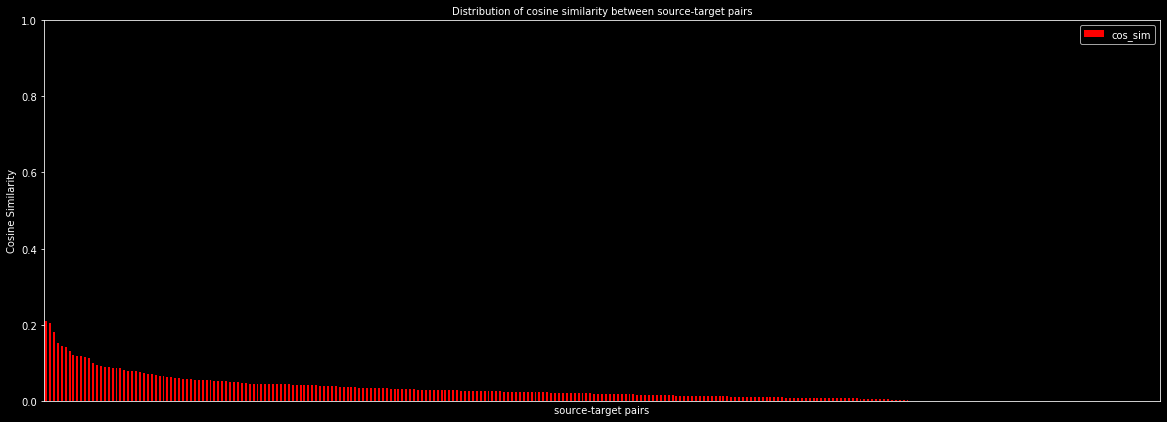

<Figure size 1440x504 with 0 Axes>

In [693]:
plt.style.use('dark_background')
mask1.plot.bar(figsize=(20,7), color = 'red')
#mask2.plot.bar(figsize=(20,7), color = 'green')
#plt.bar(mask1.index.values, mask1['cos_sim'], color='r')
#plt.bar(mask2.index.values, mask2['cos_sim'], color='g')
#pl.cos_sim.plot.bar(figsize=(20,7), color = 'green')
#pl.plot.bar(figsize=(20,7), color = 'red', pl['cos_sim'][mask2])
plt.title('Distribution of cosine similarity between source-target pairs', fontsize = 10, fontweight = 10)
plt.xlabel('source-target pairs')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Cosine Similarity')
plt.ylim((0, 1))
plt.figure(figsize=(20,7))
plt.show()

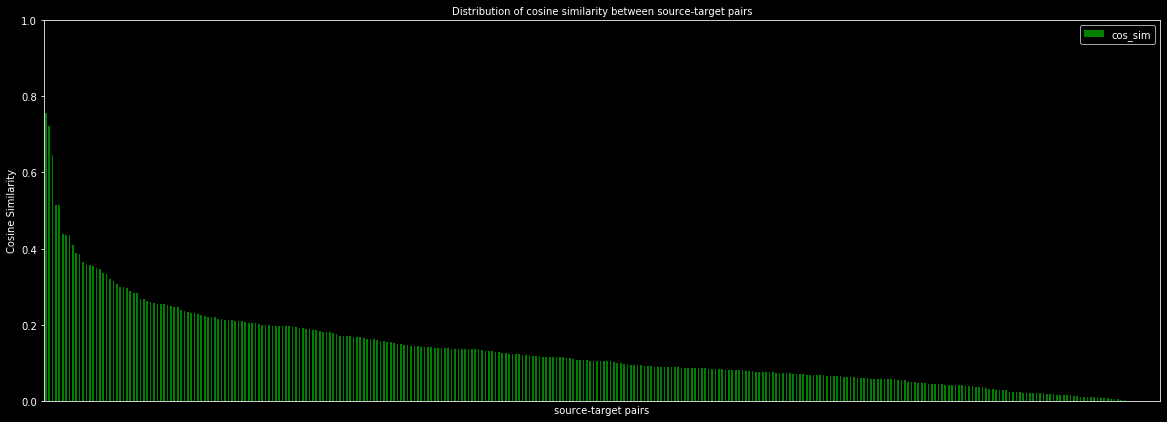

<Figure size 1440x504 with 0 Axes>

In [694]:
plt.style.use('dark_background')
#mask1.plot.bar(figsize=(20,7), color = 'red')
mask2.plot.bar(figsize=(20,7), color = 'green')
#plt.bar(mask1.index.values, mask1['cos_sim'], color='r')
#plt.bar(mask2.index.values, mask2['cos_sim'], color='g')
#pl.cos_sim.plot.bar(figsize=(20,7), color = 'green')
#pl.plot.bar(figsize=(20,7), color = 'red', pl['cos_sim'][mask2])
plt.title('Distribution of cosine similarity between source-target pairs', fontsize = 10, fontweight = 10)
plt.xlabel('source-target pairs')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.ylabel('Cosine Similarity')
plt.ylim((0, 1))
plt.figure(figsize=(20,7))
plt.show()

## Basic Graph metrics

In [391]:
# See NSA_v2.ipynb

## Node2vec

## GATConv layer

In [ ]:
import argparse
from os import path

import numpy as np
import torch
import torch.nn.functional as F
from dgl import batch
from dgl.data.ppi import LegacyPPIDataset
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch.conv import GATConv
from sklearn.metrics import f1_score
from torch import nn, optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


MODEL_STATE_FILE = path.join(path.dirname(path.abspath(__file__)), "model_state.pth")


import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


def train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset):
    train_score_list = []
    test_score_list = []
    loss_data_list = []
    loss_test_list = []
    epoch_between_two_scores = 1
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.5, patience=5, verbose=True, 
                                                           min_lr=1e-5, eps=1e-08)
    early_stopping = EarlyStopping(patience=30, verbose=False)
    for epoch in range(args.epochs):
        # train
        model.train()
        losses = []
        for batch, data in enumerate(train_dataloader):
            subgraph, features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            logits = model(subgraph, features.float())
            loss = loss_fcn(logits, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        loss_data_list.append(loss_data)
        
        loss_mean = []
        for batch, test_data in enumerate(test_dataset):
            subgraph, features, labels = test_data
            features = torch.tensor(features).to(device)
            labels = torch.tensor(labels).to(device)
            _, loss = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
            loss_mean.append(loss)
        mean_test_loss = np.array(loss_mean).mean()
        loss_test_list.append(mean_test_loss)
        scheduler.step(mean_test_loss)
        early_stopping(mean_test_loss, model)
            
        print("Epoch {:05d} | Train Loss: {:.4f} | Test Loss: {:.4f}".format(epoch + 1, loss_data, mean_test_loss))
       
        # validate
        if epoch % epoch_between_two_scores == 0:
            train_scores = []
            for batch, data in enumerate(train_dataloader):
                subgraph, features, labels = data
                features = features.to(device)
                labels = labels.to(device)
                train_score, _ = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
                train_scores.append(train_score) 
            mean_train_score = np.array(train_scores).mean()
            train_score_list.append(mean_train_score)
            
            test_scores = []
            for batch, test_data in enumerate(test_dataset):
                subgraph, features, labels = test_data
                features = torch.tensor(features).to(device)
                labels = torch.tensor(labels).to(device)
                test_score, _ = evaluate(features.float(), model, subgraph, labels.float(), loss_fcn)
                test_scores.append(test_score)
            mean_test_score = np.array(test_scores).mean()
            test_score_list.append(mean_test_score)
            print("   F1-Score | Train       {:.2%} | Test       {:.2%} ".format(mean_train_score, mean_test_score))
        
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    history = {
        'score':{
            'train': train_score_list,
            'test': test_score_list,
            'epoch_between_two_scores': epoch_between_two_scores,
        },
        'loss':{
            'train': loss_data_list,
        }
    }
    return history


def test(model, loss_fcn, device, test_dataloader):
    test_scores = []
    for batch, test_data in enumerate(test_dataloader):
        subgraph, features, labels = test_data
        features = features.to(device)
        labels = labels.to(device)
        test_scores.append(evaluate(features, model, subgraph, labels.float(), loss_fcn)[0])
    mean_scores = np.array(test_scores).mean()
    print("F1-Score: {:.4f}".format(np.array(test_scores).mean()))
    return mean_scores


def evaluate(features, model, subgraph, labels, loss_fcn):
    with torch.no_grad():
        model.eval()
        model.graph = subgraph
        output = model(subgraph, features.float())
        loss_data = loss_fcn(output, labels.float())
        predict = np.where(output.data.cpu().numpy() >= 0.5, 1, 0)
        score = f1_score(labels.data.cpu().numpy(), predict, average="micro")
        return score, loss_data.item()


def collate_fn(sample):
    graphs, features, labels = map(list, zip(*sample))
    graph = batch(graphs)
    features = torch.from_numpy(np.concatenate(features))
    labels = torch.from_numpy(np.concatenate(labels))
    return graph, features, labels

def plot_score_fc(history):
    step = history['score']['epoch_between_two_scores']
    epoch_list = range(0, len(history['score']['train']) * step, step)
    
    fig = plt.figure(figsize = (13, 6))
    ax1 = fig.add_subplot(1,1,1)
    
    train_score = history['score']['train']
    ax1.plot(epoch_list, train_score)

    test_score = history['score']['test']
    ax1.plot(epoch_list, test_score)
    
    ax1.legend(['train score',' test score'])
    ax1.set_xlabel('Epochs', size = 15)
    ax1.set_ylabel('F1-score', size = 15)
    ax1.set_title('Score of the train and test set each {step} epochs'.format(step = step), size = 20)

    ax1.set_xlim(0, epoch_list[-1])
    ax1.set_ylim(0,1)

    ax1.set_yticks([value/10 for value in range(1, 11)])
    fig.savefig('score.png')

class Model(nn.Module):

    def __init__(self, n_layers, input_size, hidden_size, output_size, nonlinearity):
        super().__init__()
        self.gat1 = GATConv(in_feats=input_size,
                                    out_feats=256,
                                    num_heads=4,
                                   activation = F.elu
                                  )
        self.gat2 = GATConv(in_feats=256 * 4,
                                    out_feats=256,
                                    num_heads=4,
                                   activation = F.elu
                                  )
        self.gat4 = GATConv(in_feats=256 * 4,
                                    out_feats=256,
                                    num_heads=4,
                                   activation = F.elu
                                  )
        self.gat3 = GATConv(in_feats=256 * 4,
                                    out_feats=121,
                                    num_heads=6,
                                   activation= F.elu
                                  )
        self.flatten1 = nn.Flatten()
        self.flatten2 = nn.Flatten()
        self.linear0 = nn.Linear(input_size, 256 * 4)
        self.linear1 = nn.Linear(256 * 4, 256 * 4)
        self.linear2 = nn.Linear(121 * 3, 121)
        self.linear3 = nn.Linear(256 * 4, 121)
        self.dropout = nn.Dropout(0.3)
    def forward(self, subgraph,  inputs):
        hidden = self.gat1(subgraph, inputs)
        hidden = self.flatten1(hidden)
        hidden2 = hidden
        hidden = (hidden + F.relu(self.dropout(self.linear0(inputs)))) / 2
        
        shortcut = hidden
        hidden = self.dropout(hidden)
        hidden = self.gat2(subgraph, hidden)
        hidden = self.flatten2(hidden)
        
        hidden2 = self.dropout(hidden2)
        hidden2 = self.gat4(subgraph, hidden2)
        hidden2 = self.flatten2(hidden2)
        
        hidden = (hidden +hidden2+ F.relu(self.dropout(self.linear1(shortcut)))) / 3
        shortcut = hidden 
        
        hidden = self.dropout(hidden)
        hidden = self.gat3(subgraph,hidden)
        hidden_mean = (hidden.mean(dim = 1) + F.relu(self.linear3(shortcut))) / 2
        hidden_max = (hidden.max(dim = 1).values + F.relu(self.linear3(shortcut))) / 2
        hidden_min = (hidden.min(dim = 1).values + F.relu(self.linear3(shortcut))) / 2
        hidden = torch.cat([hidden_mean, hidden_max, hidden_min], dim = 1)
        hidden = torch.sigmoid(self.linear2(hidden))
        return hidden

def main(args):
    # create the dataset
    train_dataset, test_dataset = LegacyPPIDataset(mode="train"), LegacyPPIDataset(mode="test")
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
    n_features, n_classes = train_dataset.features.shape[1], train_dataset.labels.shape[1]

    # create the model, loss function and optimizer
    device = torch.device("cpu" if args.gpu < 0 else "cuda:" + str(args.gpu))
    model = Model(n_layers=None, input_size=n_features,hidden_size=256, output_size=n_classes, nonlinearity=F.elu).to(device)
    loss_fcn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

    # train and test
    if args.mode == "train":
        history = train(model, loss_fcn, device, optimizer, train_dataloader, test_dataset)
        torch.save(model.state_dict(), MODEL_STATE_FILE)
        if args.verbose:
            plot_score_fc(history)
        return history, test(model, loss_fcn, device, test_dataloader)
    model.load_state_dict(torch.load(MODEL_STATE_FILE, map_location=lambda storage, loc: storage))

    return test(model, loss_fcn, device, test_dataloader)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--mode",  choices=["train", "test"], default="test")
    parser.add_argument("--gpu", type=int, default=-1, help="GPU to use. Set -1 to use CPU.")
    parser.add_argument("--epochs", type=int, default=400)
    parser.add_argument("--batch-size", type=int, default=2)
    parser.add_argument("--verbose", type=bool, default= False)
    args = parser.parse_args()
    main(args)

